<a href="https://colab.research.google.com/gist/Codesha1/b0d21ec31dd52513af7cab0d4d9708e6/-scai-training-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install networkx matplotlib pandas

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Stadium-Scale_Simulated_Path_Data (1) (2).csv to Stadium-Scale_Simulated_Path_Data (1) (2).csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('/content/Stadium-Scale_Simulated_Path_Data (1) (2).csv')
print(df.head())

             From              To  Distance_m  Congestion_Level  \
0      FoodCourt1           HallB          72              0.88   
1           HallA    ShuttleStop1          38              0.67   
2         FanZone  EmergencyExit2          73              0.80   
3  EmergencyExit1           HallB         121              0.25   
4           Gate2      FoodCourt1         160              0.72   

             class     x1     y1     x2     y2  
0       vip_access   3.37  35.13   9.60  39.62  
1     service_path  83.30  69.79  70.32  87.09  
2     service_path  37.41  96.93  18.92  82.86  
3  emergency_route  40.10  47.41  43.46  56.19  
4  emergency_route  59.32   9.94  56.31  23.90  


In [ ]:
def classify_level(level):
    if level <= 0.22:
        return 0
    elif level <= 0.35:
        return 1
    elif level <= 0.48:
        return 2
    else:
        return 3

df['Congestion_Class'] = df['Congestion_Level'].apply(classify_level)

In [ ]:
features = df[['Distance_m', 'x1', 'y1', 'x2', 'y2']]
target = df['Congestion_Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f" دقة النموذج  : {accuracy:.2f}")

 دقة النموذج  : 0.56


In [ ]:
def congestion_color(level):
    if level <= 0.22:
        return 'green'
    elif level <= 0.35:
        return 'yellow'
    elif level <= 0.48:
        return 'orange'
    else:
        return 'red'

In [ ]:
G = nx.Graph()
for _, row in df.iterrows():
    start = row['From']
    end = row['To']
    distance = row['Distance_m']
    congestion = row['Congestion_Level']

    weight = distance * (1 + congestion)

    G.add_edge(start, end, weight=weight, distance=distance, congestion=congestion)

In [ ]:
def find_best_path(G, start_point, end_point):
    try:
        path = nx.dijkstra_path(G, source=start_point, target=end_point, weight='weight')
        total_weight = nx.dijkstra_path_length(G, source=start_point, target=end_point, weight='weight')
        return path, total_weight
    except nx.NetworkXNoPath:
        return None, float('inf')

In [ ]:
start = "Gate1"
end = "Seating1"
best_path, cost = find_best_path(G, start, end)

if best_path:
    print(" أفضل مسار:", " → ".join(best_path))
    print(" التكلفة (مسافة × ازدحام):", round(cost, 2))
else:
    print(" لا يوجد مسار متاح بين النقطتين.")

 لا يوجد مسار متاح بين النقطتين.


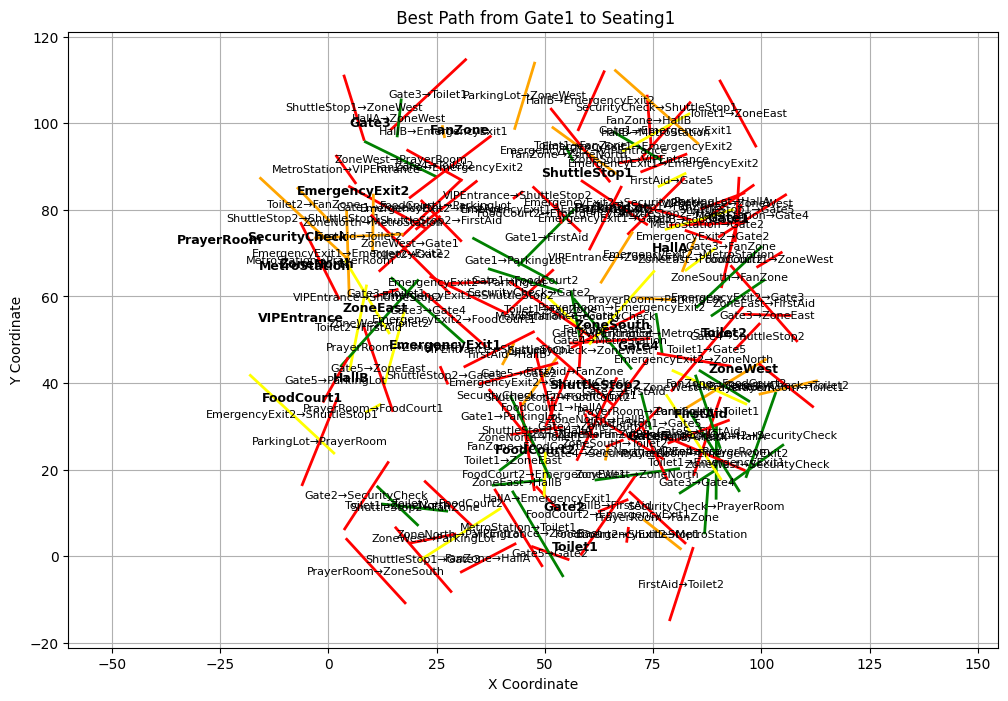

In [ ]:
plt.figure(figsize=(12, 8))

for _, row in df.sample(frac=0.2, random_state=42).iterrows():

    x1, y1 = row['x1'], row['y1']
    x2, y2 = row['x2'], row['y2']
    congestion = row['Congestion_Level']
    color = congestion_color(congestion)

    plt.plot([x1, x2], [y1, y2], color=color, linewidth=2)


    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2
    label = f"{row['From']}→{row['To']}"
    plt.text(mid_x, mid_y, label, fontsize=8, color='black', ha='center', va='center')


unique_points = set(df['From']).union(set(df['To']))
for point in unique_points:
    row_match = df[(df['From'] == point) | (df['To'] == point)].iloc[0]
    x = row_match['x1'] if row_match['From'] == point else row_match['x2']
    y = row_match['y1'] if row_match['From'] == point else row_match['y2']
    plt.text(x, y, point, fontsize=9, ha='right', va='bottom', fontweight='bold')

plt.title(f" Best Path from {start} to {end}")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.axis("equal")
plt.show()